<a href="https://colab.research.google.com/github/nikyan/spark_customer_churn/blob/master/sparkify_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparkify Project Pipeline

This Jupyter Notebook contains the execution script for loading the Sparkify dataset (12GB), extracting features, running machine learning models to predict 'churn' and finally tuning the model to achieve best results.

This Notebook is run on smaller dataset to test and present various concepts before running on a Spark cluster.

## Import Dependencies & Libraries 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# setup spark dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# setup env variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
# instantiate a spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# import libraries
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, PCA
from pyspark.ml.feature import Normalizer, MinMaxScaler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Feature Extraction

Following are all the functions that are used to extract features from the dataset and make a dataframe ready for machine learning algorithms.

In [0]:
def load_data(filename):
    
    '''
    Funtion to load data and remove null, empty strings.
    INPUT
    filename = name of file as well the path
    OUTPUT
    df - a spark dataframe with no null rows for primary key
    '''
    
    df = spark.read.json(filename)
    
    # remove empty string from userId
    df = df.filter(df.userId != "")
    
    print("Count of rows in dataframe: {}".format(df.count()))
          
    return df

In [0]:
def add_date_columns(df):
    '''
    Funtion to add date/time related columns to the dataframe.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with calculated fields: hour, month, year, day
    '''
    # create a function to get hour, month, year, day from timestamp
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
    get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
    get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)

    
    
    # add hour, month, year, day, date columns to the dataframe
    df = df.withColumn("hour", get_hour(df.ts))
    df = df.withColumn("month", get_month(df.ts))
    df = df.withColumn("year", get_year(df.ts))
    df = df.withColumn("day", get_day(df.ts))
    df = df.withColumn("date", from_unixtime(df.ts/1000).cast(DateType()))
    
    
    return df

In [0]:
def get_flag_churn(df):
    '''
    Funtion to add churn flag that identifies whether a user has churned.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with userId of each user, churn flag and gender
    '''
    
    # function to flag 'cancellation confirmation' event
    flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", flag_cancel_event("page"))
    user_churn = df.groupBy("userId").agg({"churn":"max", "gender":"max"})\
                           .withColumnRenamed("max(churn)", "label")\
                           .withColumnRenamed("max(gender)", "gender")
    
    #print("Count of rows: {}".format(user_churn.count()))
    return user_churn

In [0]:
def get_latest_level(df):
    '''
    Funtion to find the latest level of each user.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with userId of each user and latest level
    '''
    # use timestamp to identify the most latest record for a user
    # sort timestamp in descending order and than drop duplicates to get the last row for each user
    latest_level = df.select(["userId", "level", "ts"])\
                        .orderBy(desc("ts"))\
                        .dropDuplicates(["userId"])\
                        .select(["userId", "level"])
    #print("Count of rows: {}".format(latest_level.count()))
    return latest_level

In [0]:
def get_states(df):
    '''
    Funtion to clean location column and return cleaned state names.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with userId of each user and state from location
    '''
    # get location of each user
    state_data = df.groupBy("userId").agg({"location":"max"}).withColumnRenamed("max(location)", "state")
    # extract state
    state_data = state_data.withColumn("state", split(col("state"),',').getItem(1))
    
    #print("Count of rows: {}".format(state_data.count()))
    
    return state_data

In [0]:
def get_device(df):
    '''
    Funtion to clean userAgent column and return cleaned device/os names.
    INPUT:
    df - a spark dataframe
    OUPUT:
    device_data - a spark dataframe with userId of each user and device/os name
    '''
      
    device_data = df.groupBy("userId").agg({"userAgent":"max"}).withColumnRenamed("max(userAgent)", "device")
    device_data = device_data.withColumn("device", regexp_extract(col("device"), r'\((.*?)\)', 1));
    
    device_data = device_data.withColumn("device", split(col("device"),';').getItem(0))
    device_data = device_data.withColumn("device", split(col("device"),'NT').getItem(0))
    
    device_data = device_data.withColumn("device", trim(device_data.device))
    
    #print("Count of rows: {}".format(device_data.count()))
    
    return device_data

In [0]:
def get_days_since_reg(df):
    '''
    Funtion to get the number of days since registration
    INPUT:
    df - a spark dataframe
    OUPUT:
    days_since_reg - a spark dataframe with userId of each user and days since registration
    '''
    
    # replace null in 'registration' or 'ts' field with 0
    df = df.fillna(0, subset=['registration', 'ts'])
    
    get_subtract_ts = udf(lambda x, y: datetime.datetime.fromtimestamp((y - x) / 1000.0).day, IntegerType())

    days_since_reg = df.groupBy("userId").agg({"registration":"max", "ts":"max"})\
                                         .withColumnRenamed("max(registration)", "max_reg")\
                                         .withColumnRenamed("max(ts)", "max_ts")
    
    days_since_reg = days_since_reg.withColumn("days_since_reg", when(col('max_reg') != 0, get_subtract_ts(col('max_reg'), col('max_ts'))).otherwise(0))
    
    days_since_reg = days_since_reg.drop("max_reg")
    days_since_reg = days_since_reg.drop("max_ts")
    
    #print("Count of rows: {}".format(days_since_reg.count()))
    
    return days_since_reg

In [0]:
def get_avg_count_session(df):
    '''
    Funtion to get the average number of sessions per month for a user
    INPUT:
    df - a spark dataframe
    OUPUT:
    avg_count_session - a spark dataframe with userId of each user and average monthly count of sessions
    '''
    mon_count_session = df.groupBy("userId", "month").agg(countDistinct("sessionId"))\
                          .groupBy("userId").agg(avg("count(DISTINCT sessionId)"))\
                          .withColumnRenamed("avg(count(DISTINCT sessionId))", "avg_mon_session_count")
    
    #print("Count of rows: {}".format(mon_count_session.count()))
    
    return mon_count_session

In [0]:
def get_avg_duration_session(df):
    '''
    Funtion to get the average number of sessions per month for a user
    INPUT:
    df - a spark dataframe
    OUPUT:
    avg_duration_session - a spark dataframe with userId of each user and average monthly count of sessions
    '''
    
    mon_sess_duration = df.groupBy("userId", "month").agg(max("ts"), min("ts"))\
                          .withColumn("duration", (col("max(ts)") - col("min(ts)"))/1000)\
                          .groupBy("userId").agg(avg("duration"))\
                          .withColumnRenamed("avg(duration)", "avg_mon_sess_duration")
    
    #print("Count of rows: {}".format(mon_sess_duration.count()))
    
    return mon_sess_duration

In [0]:
def get_avg_page_views(df):
    '''
    Funtion to get the average number of page views per date and month for a user
    INPUT:
    df - a spark dataframe
    OUPUT:
    avg_page_views - a spark dataframe with userId of each user and average monthly page views with each page pivoted
    '''
    # --------------- Monthly views -----------------:
    # get avg of page views per month
    avg_mon_page_views = df.groupBy("userId", "page", "month").agg(count("page"))\
                           .groupBy("userId", "page").agg(avg("count(page)"))\
                           .withColumnRenamed("avg(count(page))", "avg_page_count")
    
    # clean up page column
    avg_mon_page_views = avg_mon_page_views.withColumn("page", trim(avg_mon_page_views.page))
    avg_mon_page_views = avg_mon_page_views.withColumn("page", regexp_replace(avg_mon_page_views.page, " ", "_"))
    
    # add prefix to each page name
    add_prefix = udf(lambda x: "avg_mon_" + x)
    avg_mon_page_views = avg_mon_page_views.withColumn("page", add_prefix(avg_mon_page_views.page))
    
    # pivot page names to get columns
    avg_mon_page_views = avg_mon_page_views.groupBy("userId").pivot("page").max("avg_page_count")
    avg_mon_page_views = avg_mon_page_views.fillna(0)
    
    # ---------------- Daily views --------------------:
    # get avg of page views per day
    avg_daily_page_views = df.groupBy("userId", "page", "date").agg(count("page"))\
                           .groupBy("userId", "page").agg(avg("count(page)"))\
                           .withColumnRenamed("avg(count(page))", "avg_daily_page_count")
    
    # clean up page column
    avg_daily_page_views = avg_daily_page_views.withColumn("page", trim(avg_daily_page_views.page))
    avg_daily_page_views = avg_daily_page_views.withColumn("page", regexp_replace(avg_daily_page_views.page, " ", "_"))
    
    # add prefix to each page name
    add_prefix_daily = udf(lambda x: "avg_daily_" + x)
    avg_daily_page_views = avg_daily_page_views.withColumn("page", add_prefix_daily(avg_daily_page_views.page))
    
    # pivot page names to get columns
    avg_daily_page_views = avg_daily_page_views.groupBy("userId").pivot("page").max("avg_daily_page_count")
    avg_daily_page_views = avg_daily_page_views.fillna(0)

    # join daily and monthly views.
    avg_page_views = avg_daily_page_views.join(avg_mon_page_views, on="userId")

    #print("Count of rows: {}".format(avg_mon_page_views.count()))

    
    return avg_page_views

In [0]:
def extract_features(df):
    '''
    Funtion to extract feautres from the log data.
    INPUT:
    df - a spark dataframe
    OUPUT:
    df - a spark dataframe with userId as set of unique rows and columns with features extracted
    '''

    # add date columns
    df = add_date_columns(df)

    # get churn and gender columns
    user_label = get_flag_churn(df)

    # get latest level of the user
    latest_level = get_latest_level(df)

    # extract states from location
    states = get_states(df)

    # extract device/os from userAgent
    device = get_device(df)

    # get days since registration
    days_since_reg = get_days_since_reg(df)

    # get average monthly count of sessions per user
    avg_count_session = get_avg_count_session(df)

    # get average monthly duration of sessions per user
    avg_duration_session = get_avg_duration_session(df)

    # get average monthly page views per page per user
    avg_page_views = get_avg_page_views(df)


    # join all extracted tables
    user_data_all = user_label.join(latest_level, on="userId")\
                              .join(states, on="userId")\
                              .join(device, on="userId")\
                              .join(days_since_reg, on="userId")\
                              .join(avg_count_session, on="userId")\
                              .join(avg_duration_session, on="userId")\
                              .join(avg_page_views, on="userId")

    # check count
    x1 = user_data_all.count()
    x2 = event_data.select("userId").dropDuplicates().count()
    if (x1 == x2):
      print("The number of rows in final merged table ({}) matches number of unique users ({}).".format(x1, x2))
    else:
      print("The numebr of rows in final merged tables ({}) do not match number of unique users ({}).".format(x1, x2))


    # check for nans and nulls
    user_data_all.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_data_all.columns]).show()

    return user_data_all

## Modeling

### Data transformation for ML algorithms

In [0]:
def transform_data(df, numerical_col, categorical_col, pca=10):
    '''
    Function to transform categorical fields and create features vector. The function uses Pipeline to convert string to numerical, 
    vectorize, standardize and perform PCA.
    INPUT:
    df - a spark dataframe
    numerical_col - a list of numerical columns that should be used in ML models
    categorical_col - a list of categorical columns that should be used in ML models
    pca - a number of principal components to retain for ML models. Default value is 10.
    OUPUT:
    df - a spark dataframe with transformed data containing features, scaledFeatures and pcaFeatures vector
    '''
    
    # Define stringIndexer for converting categorical to numerical variables
    # Apply VectorAssembler to create feature vector
    # Normalize data before performing PCA
    # Perform PCA for feature selection
    # Use pipeline to create ML ready data
    

    # convert categorical columns to numerical
    stages = []
    for col in categorical_col:
        stringIndexer = StringIndexer(inputCol = col, outputCol = col + '_index', handleInvalid = 'keep')
        #encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "_classVec"])
        #stages += [stringIndexer, encoder]
        stages += [stringIndexer]

    # vectorize columns
    assemblerInputs = [c + "_index" for c in categorical_col] + numerical_col
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    

    # Rescale feature vector
    # scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",   withStd=True, withMean=False)
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    stages += [scaler]
    
    pca = PCA(k=pca, inputCol="scaledFeatures", outputCol="pcaFeatures")
    stages += [pca]


    # use pipeline to transform data
    cols = df.columns
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    df = pipelineModel.transform(df)
    
    #select new 'feature' column and rest of columns
    selectedCols = ['features', 'scaledFeatures', 'pcaFeatures'] + cols
    df = df.select(selectedCols)

    return df

### Baseline models testing

In [0]:
def model_testing(model, train, test):
    '''
    Funtion to test baseline machine learning algorithms
    INPUT:
    model - instantiated model object
    train - training dataset
    test - testing dataset
    OUPUT:
    score - F1 score to measure performance of the algorithm
    '''
       
    cl_model = model.fit(train)
    predict_train = cl_model.transform(train)
    predict_test = cl_model.transform(test)

    # Because of imbabalnced dataset, it is preferred to use F1 score as evaluation metric
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    score_train = evaluator.evaluate(predict_train)
    score_test = evaluator.evaluate(predict_test)

    return score_train, score_test

### Parameter tuning

In [0]:
def model_tuning(train, test, model, paramGrid, numFolds):
    '''
    Funtion to tune a machine learning algorithm using cross validation
    INPUT:
    model - instantiated model object
    paramGrid - hyper parameters associated with the model used for tuning
    numFolds - number of cross validation folds
    train - training dataset
    test - testing dataset
    
    OUPUT:
    score_train - F1 score to measure performance of the algorithm on training dataset
    score_test - F1 score to measure performance of the algorithm on testing dataset
    predict_train - dataframe with prediction results from transformation on training dataset
    predict_test - dataframe with prediction results from transformation on testing dataset
    bestModel - best model object to get the best parameters from the paramGrid
    '''
    
    # instantiate evaluator with F1 score as metric
    evaluator = MulticlassClassificationEvaluator(metricName="f1")

    # instantiate cross validation object
    cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=numFolds)
    
    # fit and transform
    cvmodel = cv.fit(train)
    predict_train = cvmodel.transform(train)
    predict_test = cvmodel.transform(test)
    
    # get the f1 score
    score_train = evaluator.evaluate(predict_train)
    score_test = evaluator.evaluate(predict_test)
    
    bestModel = cvmodel.bestModel
    
    return score_train, score_test, predict_train, predict_test, bestModel
    

## Execution

### 1. Load dataset

In [20]:
# link to mini dataset
path = "/content/drive/My Drive/ML data/mini_sparkify_event_data.json"

# load Spark dataframe
event_data = load_data(path)

Count of rows in dataframe: 278154


In [172]:
# check for nans and nulls
event_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [168]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 2. Extract features

In [21]:
%%time
user_data_all = extract_features(event_data)

The number of rows in final merged table (225) matches number of unique users (225).
+------+------+-----+-----+-----+------+--------------+---------------------+---------------------+---------------+--------------------+-------------------------+----------------+-----------------------------------+-------------------+---------------+--------------+--------------+----------------+------------------+---------------------+-----------------------+------------------+--------------------------+------------------------+---------------------+-------------------+-----------------+-------------+------------------+-----------------------+--------------+---------------------------------+-----------------+-------------+------------+------------+--------------+----------------+-------------------+---------------------+----------------+------------------------+----------------------+-------------------+-----------------+---------------+
|userId|gender|label|level|state|device|days_since_reg|avg_mon_

In [174]:
# check schema for all columns
user_data_all.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- state: string (nullable = true)
 |-- device: string (nullable = true)
 |-- days_since_reg: integer (nullable = true)
 |-- avg_mon_session_count: double (nullable = true)
 |-- avg_mon_sess_duration: double (nullable = true)
 |-- avg_daily_About: double (nullable = false)
 |-- avg_daily_Add_Friend: double (nullable = false)
 |-- avg_daily_Add_to_Playlist: double (nullable = false)
 |-- avg_daily_Cancel: double (nullable = false)
 |-- avg_daily_Cancellation_Confirmation: double (nullable = false)
 |-- avg_daily_Downgrade: double (nullable = false)
 |-- avg_daily_Error: double (nullable = false)
 |-- avg_daily_Help: double (nullable = false)
 |-- avg_daily_Home: double (nullable = false)
 |-- avg_daily_Logout: double (nullable = false)
 |-- avg_daily_NextSong: double (nullable = false)
 |-- avg_daily_Roll_Advert: double (nullable =

### 3. Data Prep before ML

#### 3.1 Check correlations

In [0]:
# get list of categorical columns
str_cols = [item[0] for item in user_data_all.dtypes if item[1].startswith('string')]
# remove userId since it's not required for modeling
str_cols.remove('userId')

# get list of numerical columns
num_cols = [item[0] for item in user_data_all.dtypes if not item[1].startswith('string')]
# remove label column since it's what we are predicting
num_cols.remove('label')

In [23]:
str_cols

['gender', 'level', 'state', 'device']

In [24]:
num_cols

['days_since_reg',
 'avg_mon_session_count',
 'avg_mon_sess_duration',
 'avg_daily_About',
 'avg_daily_Add_Friend',
 'avg_daily_Add_to_Playlist',
 'avg_daily_Cancel',
 'avg_daily_Cancellation_Confirmation',
 'avg_daily_Downgrade',
 'avg_daily_Error',
 'avg_daily_Help',
 'avg_daily_Home',
 'avg_daily_Logout',
 'avg_daily_NextSong',
 'avg_daily_Roll_Advert',
 'avg_daily_Save_Settings',
 'avg_daily_Settings',
 'avg_daily_Submit_Downgrade',
 'avg_daily_Submit_Upgrade',
 'avg_daily_Thumbs_Down',
 'avg_daily_Thumbs_Up',
 'avg_daily_Upgrade',
 'avg_mon_About',
 'avg_mon_Add_Friend',
 'avg_mon_Add_to_Playlist',
 'avg_mon_Cancel',
 'avg_mon_Cancellation_Confirmation',
 'avg_mon_Downgrade',
 'avg_mon_Error',
 'avg_mon_Help',
 'avg_mon_Home',
 'avg_mon_Logout',
 'avg_mon_NextSong',
 'avg_mon_Roll_Advert',
 'avg_mon_Save_Settings',
 'avg_mon_Settings',
 'avg_mon_Submit_Downgrade',
 'avg_mon_Submit_Upgrade',
 'avg_mon_Thumbs_Down',
 'avg_mon_Thumbs_Up',
 'avg_mon_Upgrade']

In [0]:
# select numerical columns and convert to pandas dataframe
user_data_all_pd = user_data_all.select(num_cols).toPandas()

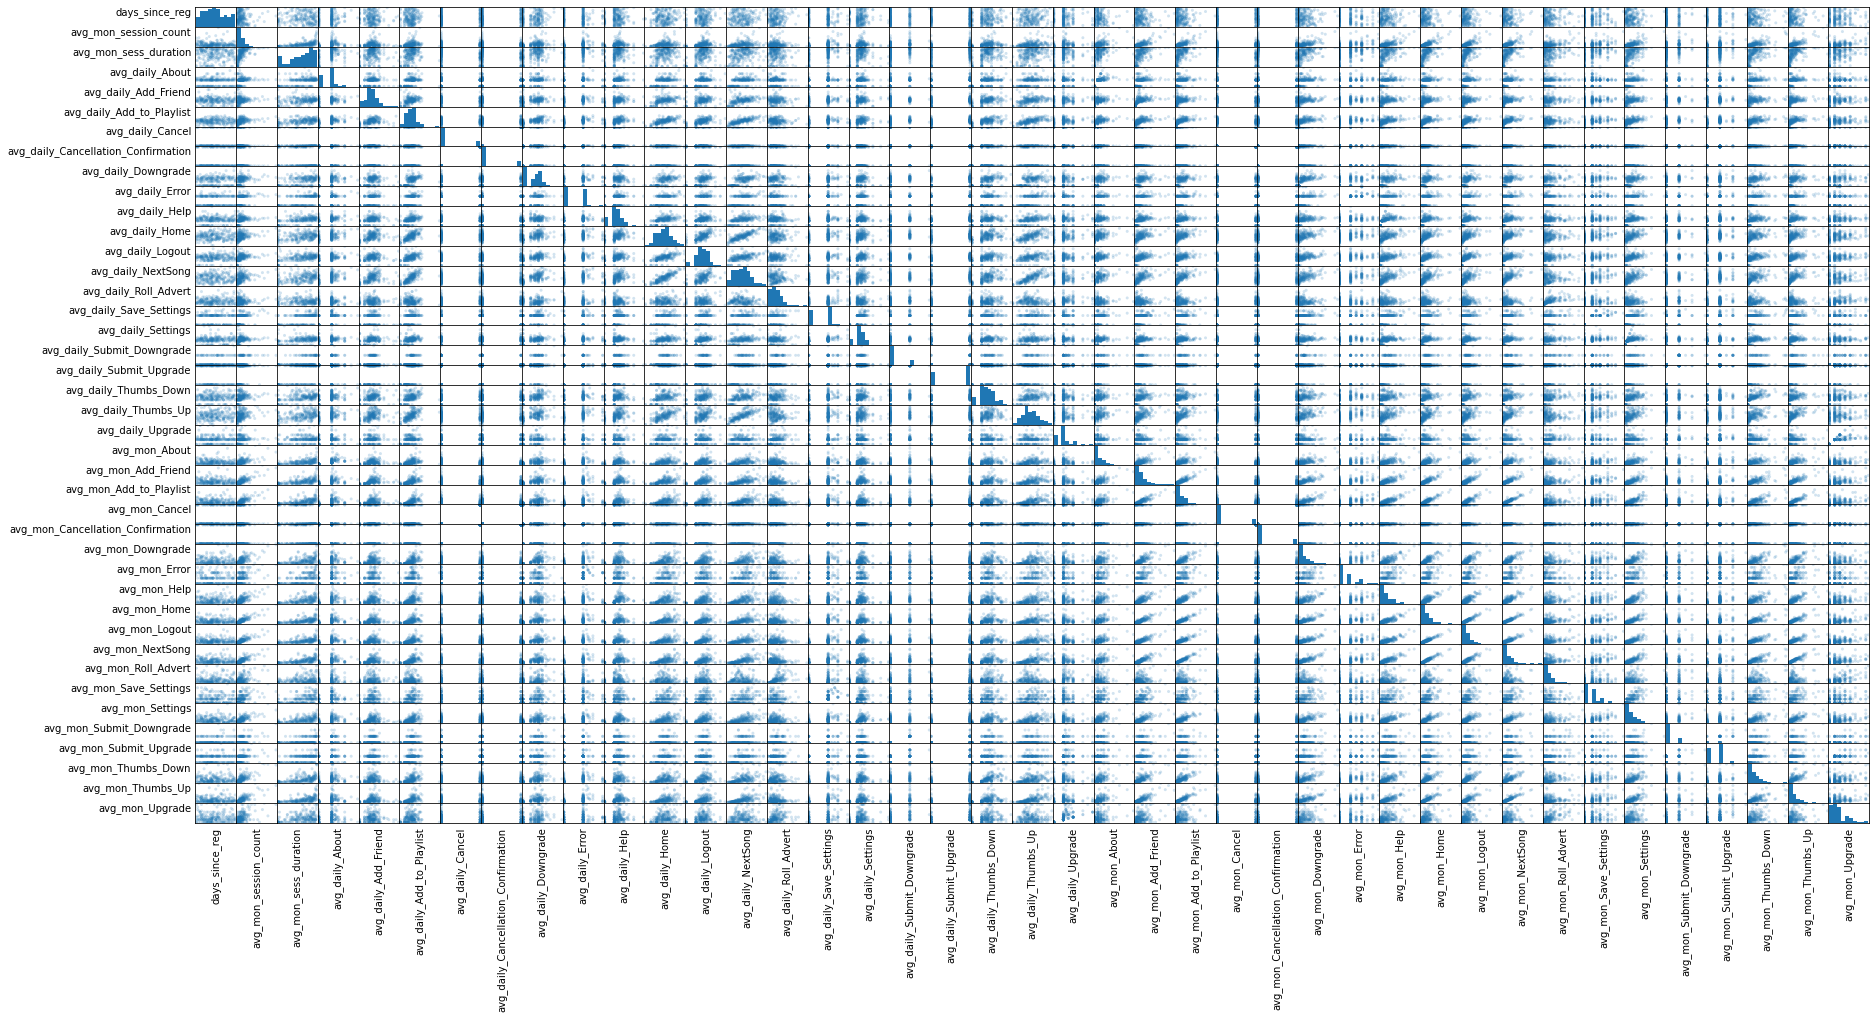

In [73]:
%%time
# plot correlation matrix
axs = pd.plotting.scatter_matrix(user_data_all_pd, figsize=(30, 15), alpha=0.2);

# Rotate axis labels and remove axis ticks
col = len(user_data_all_pd.columns)
for i in range(col):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[col-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

As we can see some of the columns are highly correlated. We will use PCA to remove some of these columns.

***Remove 'Cancel' and 'Cancellation_Confirmation' pages since we want to predict churn before we reach these pages.***

In [0]:
# remove 'Cancel' and 'Cancellation_Confirmation' pages since we want to predict churn before we reach these pages.
num_cols.remove('avg_daily_Cancel')
num_cols.remove('avg_daily_Cancellation_Confirmation')

num_cols.remove('avg_mon_Cancel')
num_cols.remove('avg_mon_Cancellation_Confirmation')

#### 3.2 Transform data using Pipelines

Transform dataset to get scaledFeatures and default PCA=10. PCA analysis will be performed later on 'scaledFeatures' to ascertain the best value for PCA features. We can come back re-run this block of code if want to add more features beyond 10.

In [28]:
%%time
user_data_all_trans = transform_data(user_data_all, num_cols, str_cols, 10)

CPU times: user 1.26 s, sys: 543 ms, total: 1.8 s
Wall time: 2min 42s


In [182]:
user_data_all_trans.head()

Row(features=DenseVector([1.0, 1.0, 4.0, 2.0, 25.0, 3.5, 1232078.0, 1.0, 1.3333, 1.4, 0.0, 0.0, 1.0, 1.8333, 1.0, 39.2857, 8.6667, 0.0, 0.0, 0.0, 0.0, 1.25, 2.8333, 1.0, 1.0, 2.0, 3.5, 0.0, 0.0, 1.0, 5.5, 2.5, 137.5, 26.0, 0.0, 0.0, 0.0, 0.0, 2.5, 8.5, 1.0]), scaledFeatures=DenseVector([1.0, 1.0, 0.0702, 0.4, 0.8, 0.0472, 0.4696, 0.3333, 0.1667, 0.14, 0.0, 0.0, 0.25, 0.2619, 0.25, 0.2277, 0.619, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.3047, 0.25, 0.08, 0.028, 0.0292, 0.0, 0.0, 0.0435, 0.031, 0.0403, 0.0336, 0.4062, 0.0, 0.0, 0.0, 0.0, 0.0667, 0.0389, 0.1333]), pcaFeatures=DenseVector([0.1991, 1.1957, -0.8043, -0.1937, 0.417, -0.6206, 0.3121, 0.3937, -0.6565, -0.1843]), userId='100010', gender='F', label=0, level='free', state=' CT', device='iPhone', days_since_reg=25, avg_mon_session_count=3.5, avg_mon_sess_duration=1232078.0, avg_daily_About=1.0, avg_daily_Add_Friend=1.3333333333333333, avg_daily_Add_to_Playlist=1.4, avg_daily_Cancel=0.0, avg_daily_Cancellation_Confirmation=0.0, avg_daily_Downg

#### 3.3 Perform PCA

Perform PCA to evaluate feature importance.


In [97]:
cols = str_cols + num_cols
len(cols)

41

In [0]:
user_data_all_pcs = user_data_all_trans.select('scaledFeatures')

In [0]:
pca = PCA(k=len(cols), inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(user_data_all_pcs)

result = model.transform(user_data_all_pcs).select("pcaFeatures")
#result.show(truncate=False)

Scree Plot:

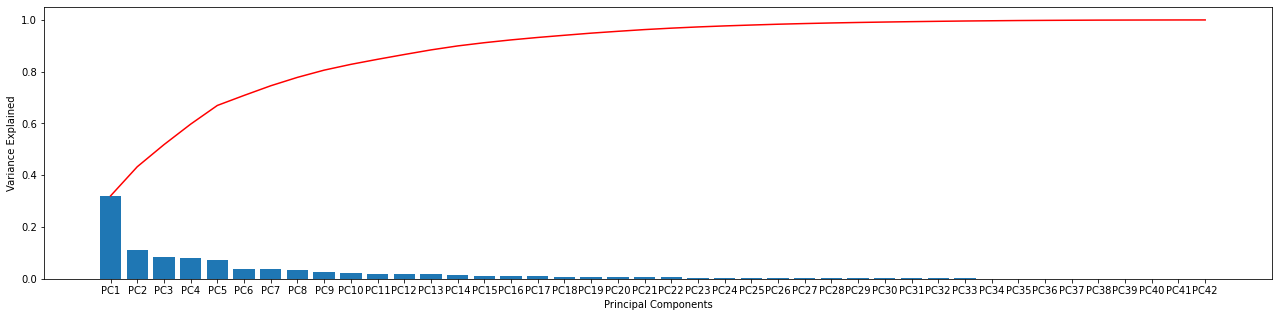

In [85]:
plt.figure(figsize=(22,5))
pca_df = pd.DataFrame({'var': model.explainedVariance, 'PC': ['PC'+ str(i) for i in range(1, len(cols)+1)]})
pca_df.set_index('PC')
pca_df['cum_var'] = pca_df['var'].cumsum()
plt.bar(x='PC',height="var", data=pca_df)
plt.ylabel('Variance Explained')
plt.xlabel('Principal Components')
plt.plot(pca_df['PC'], pca_df['cum_var'], c='red');

This is the plot of all Principal Components. The red line shows the cumulative value of princial components and allows us to determine the number of factors to retain.

In [86]:
pca_df[0:20]

,var,PC,cum_var
0,0.320217,PC1,0.320217
1,0.112660,PC2,0.432877
2,0.085329,PC3,0.518206
3,0.079272,PC4,0.597478
4,0.072204,PC5,0.669682
5,0.038707,PC6,0.708389
6,0.037324,PC7,0.745713
7,0.032460,PC8,0.778173
8,0.027899,PC9,0.806072
9,0.022324,PC10,0.828397


20 features cover 95% of the variability in the dataset while 10 features cover 85% of the variability in the dataset.

#### 3.4 Imbalanced dataset

A dataset is considered imbalanced if the ratio of one class is much higher than another class. In this dataset, the number of users who have churned are way less than number of active users. This poses a problem with classification models where all classes are not represented equally.

In [183]:
major_df = user_data_all_trans.filter(user_data_all_trans.label == 0)
minor_df = user_data_all_trans.filter(user_data_all_trans.label == 1)
ratio_df = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio_df))

ratio: 3


The data is heavily skewed towards label == 0 i.e. there are way more active users than churned users. Because the prediction classs is imbalanced, the ML models will be heavily skewed towards predicting label 0. In order to circumvent this situation, 'weights' column is created to provide more weight to the minority class. 

In [0]:
# add new column weights
# use user defined ratio field to provide appropriate weights to majority and minority class
ratio = 1/ratio_df
user_data_all_trans = user_data_all_trans.withColumn("weights", when(user_data_all_trans.label == 1, ratio).otherwise(1-ratio))

In [185]:
user_data_all_trans.head()

Row(features=DenseVector([1.0, 1.0, 4.0, 2.0, 25.0, 3.5, 1232078.0, 1.0, 1.3333, 1.4, 0.0, 0.0, 1.0, 1.8333, 1.0, 39.2857, 8.6667, 0.0, 0.0, 0.0, 0.0, 1.25, 2.8333, 1.0, 1.0, 2.0, 3.5, 0.0, 0.0, 1.0, 5.5, 2.5, 137.5, 26.0, 0.0, 0.0, 0.0, 0.0, 2.5, 8.5, 1.0]), scaledFeatures=DenseVector([1.0, 1.0, 0.0702, 0.4, 0.8, 0.0472, 0.4696, 0.3333, 0.1667, 0.14, 0.0, 0.0, 0.25, 0.2619, 0.25, 0.2277, 0.619, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.3047, 0.25, 0.08, 0.028, 0.0292, 0.0, 0.0, 0.0435, 0.031, 0.0403, 0.0336, 0.4062, 0.0, 0.0, 0.0, 0.0, 0.0667, 0.0389, 0.1333]), pcaFeatures=DenseVector([0.1991, 1.1957, -0.8043, -0.1937, 0.417, -0.6206, 0.3121, 0.3937, -0.6565, -0.1843]), userId='100010', gender='F', label=0, level='free', state=' CT', device='iPhone', days_since_reg=25, avg_mon_session_count=3.5, avg_mon_sess_duration=1232078.0, avg_daily_About=1.0, avg_daily_Add_Friend=1.3333333333333333, avg_daily_Add_to_Playlist=1.4, avg_daily_Cancel=0.0, avg_daily_Cancellation_Confirmation=0.0, avg_daily_Downg

'weights' column will be used in logistic regression becuase the model itself has an in-build parameter to handle imbalanced dataset.

### 4. Split data into training and testing datasets

In [32]:
%%time
# split data for training and testing datasets
train, test = user_data_all_trans.randomSplit([0.7, 0.3], seed=42)
print(train.count())
print(test.count())

163
62
CPU times: user 478 ms, sys: 196 ms, total: 674 ms
Wall time: 1min 11s


#### 5.1 Save data before running ML models for later load.

In [0]:
# # save parquet file - save data
# train.write.parquet("/train.parquet")

In [0]:
# # save parquet file - save data
# test.write.parquet("/test_05-30.parquet")

In [0]:
# # using SQLContext to read parquet file
# from pyspark.sql import SQLContext
# sqlContext = SQLContext(sc)

# # to read parquet file
# train = sqlContext.read.parquet("/train.parquet")
# test = sqlContext.read.parquet("/test.parquet")

### 5. Run baseline models

#### Instantiate model objects
Run models with default parameters.

In [0]:
# Logistic Regression
lr_model = LogisticRegression(featuresCol = 'pcaFeatures', labelCol = 'label')
lr_model_w = LogisticRegression(featuresCol = 'pcaFeatures', labelCol = 'label', weightCol='weights')

# Gradient Boosting Trees (GBT)
gbt_model = GBTClassifier(featuresCol = 'pcaFeatures', labelCol = 'label')

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(featuresCol = 'pcaFeatures', labelCol = 'label')

# RandomForest Classifier
rf_model = RandomForestClassifier(featuresCol = 'pcaFeatures', labelCol = 'label')

#### F1 score for each model

f1 score is a measure of accuracy that uses both precision and recall. 

f1 = 2*((precision*recall)/(precision+recall))

Since we are dealing with imbalanced dataset where churned users much less than active users, it's best to use f1 score rather than accuracy which may provide high accuracy by just predicting majority class.

In [140]:
# Logistic Regression without weights
%%time
lr_score_train, lr_score_test = model_testing(lr_model, train, test)
print("f1 score for Logistic Regression: train dataset {}, test dataset {}".format(lr_score_train, lr_score_test))

f1 score for Logistic Regression: train dataset 0.7858870909260187, test dataset 0.6371574096531651
CPU times: user 1.02 s, sys: 537 ms, total: 1.56 s
Wall time: 2min 19s


In [141]:
# Logistic Regression with weights
%%time
lr_score_train_w, lr_score_test_w = model_testing(lr_model_w, train, test)
print("f1 score for Logistic Regression: train dataset {}, test dataset {}".format(lr_score_train_w, lr_score_test_w))

f1 score for Logistic Regression: train dataset 0.744501246670931, test dataset 0.6104914078987036
CPU times: user 1.03 s, sys: 530 ms, total: 1.56 s
Wall time: 2min 21s


We don't observe a lot of diference between Logistic Regression using 'weights' and Logistic Regression without 'weights'.

In [142]:
%%time
gbt_score_train, gbt_score_test = model_testing(gbt_model, train, test)
print("f1 score for GBT Classifier: train dataset {}, test dataset {}".format(gbt_score_train, gbt_score_test))

f1 score for GBT Classifier: train dataset 1.0, test dataset 0.5590535663698285
CPU times: user 2.21 s, sys: 1.31 s, total: 3.52 s
Wall time: 3min 55s


In [143]:
%%time
dt_score_train, dt_score_test = model_testing(dt_model, train, test)
print("f1 score for Decision Tree Classifier: train dataset {}, test dataset {}".format(dt_score_train, dt_score_test))

f1 score for Decision Tree Classifier: train dataset 0.9552409018690015, test dataset 0.588978494623656
CPU times: user 940 ms, sys: 458 ms, total: 1.4 s
Wall time: 2min 40s


In [144]:
%%time
rf_score_train, rf_score_test = model_testing(rf_model, train, test)
print("f1 score for Random Forest Classifier: train dataset {}, test dataset {}".format(rf_score_train, rf_score_test))

f1 score for Random Forest Classifier: train dataset 0.8572063661420823, test dataset 0.6104914078987036
CPU times: user 982 ms, sys: 449 ms, total: 1.43 s
Wall time: 2min 47s


Logistic Regression performs the best.

### 6. Parameter tuning

#### Paramter tuning for Logistic Regression:

In [0]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr_model.aggregationDepth,[2,5])\
    .addGrid(lr_model.maxIter,[10, 100])\
    .addGrid(lr_model.regParam,[0.01, 0.1])\
    .build()

In [162]:
%%time
score_train_lr, score_test_lr, predict_train_lr, predict_test_lr, bestModel_lr = model_tuning(train, test, lr_model, paramGrid, 5)

CPU times: user 16.6 s, sys: 10.1 s, total: 26.7 s
Wall time: 20min 29s


In [163]:
print("f1 score train dataset: {}".format(score_train_lr))
print("f1 score test dataset: {}".format(score_test_lr))
print("Best parameter for Aggregation depth: {}".format(bestModel_lr._java_obj.getAggregationDepth()))
#print("Best parameter for Elastic Net param: {}".format(bestModel_lr._java_obj.getElasticNetParam()))
#print("Best parameter for Fit Intercept: {}".format(bestModel_lr._java_obj.getFitIntercept()))
print("Best parameter for iterations: {}".format(bestModel_lr._java_obj.getMaxIter()))
print("Best parameter for param: {}".format(bestModel_lr._java_obj.getRegParam()))

f1 score train dataset: 0.7853868274178938
f1 score test dataset: 0.6467167106241969
Best parameter for Aggregation depth: 2
Best parameter for iterations: 10
Best parameter for param: 0.01


In [164]:
# check whether prediction consists of both labels.
predict_test_lr.select("prediction").dropDuplicates().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



#### Parameter tuning for Random forest classifier:

In [0]:
# param grid for random forest classifier
rf_paramGrid = ParamGridBuilder()\
              .addGrid(rf_model.maxDepth,[5])\
              .addGrid(rf_model.numTrees,[50, 100])\
              .addGrid(rf_model.maxBins,[50, 100])\
              .build()

In [158]:
%%time
score_train_rf, score_test_rf, predict_train_rf, predict_test_rf, bestModel_rf = model_tuning(train, test, rf_model, rf_paramGrid, 5)

CPU times: user 7.75 s, sys: 3.63 s, total: 11.4 s
Wall time: 17min 18s


In [159]:
print("f1 score on train dataset: {}".format(score_train_rf))
print("f1 score on test dataset: {}".format(score_test_rf))
print("Best parameter for max depth: {}".format(bestModel_rf._java_obj.getMaxDepth()))
print("Best parameter for number of tress: {}".format(bestModel_rf._java_obj.getNumTrees()))
print("Best parameter for number of bins: {}".format(bestModel_rf._java_obj.getMaxBins()))

f1 score on train dataset: 0.9056009997727789
f1 score on test dataset: 0.6104914078987036
Best parameter for max depth: 5
Best parameter for number of tress: 50
Best parameter for number of bins: 50


In [160]:
# check whether prediction consists of both labels.
predict_test_rf.select("prediction").dropDuplicates().show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+



#### Parameter tuning for Decision Tree classifier:

In [0]:
# param grid for random forest classifier
dt_paramGrid = ParamGridBuilder()\
              .addGrid(dt_model.maxDepth,[5, 10, 15])\
              .addGrid(dt_model.maxBins,[100, 150, 200])\
              .build()

In [151]:
%%time
score_train_dt, score_test_dt, predict_train_dt, predict_test_dt, bestModel_dt = model_tuning(train, test, dt_model, dt_paramGrid, 5)

CPU times: user 11.6 s, sys: 6.52 s, total: 18.1 s
Wall time: 17min 12s


In [155]:
print("f1 score on train dataset: {}".format(score_train_dt))
print("f1 score on test dataset: {}".format(score_test_dt))
print("Best parameter for max depth: {}".format(bestModel_dt._java_obj.getMaxDepth()))
print("Best parameter for number of bins: {}".format(bestModel_dt._java_obj.getMaxBins()))

f1 score on train dataset: 0.9263803680981595
f1 score on test dataset: 0.6157184750733136
Best parameter for max depth: 5
Best parameter for number of bins: 100


In [153]:
# check whether prediction consists of both labels.
predict_test_dt.select("prediction").dropDuplicates().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



Logistic Regression and Decision Tree classifier perform little better than Random forest classifier. Random Forest is only predicting the majority class label.
There is obviously scope for improvement and further tuning of the model.

Also, note that the above models are run on only mini dataset and hence may not provide enough data points for the models to effective.